In [6]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    data_dict = pd.read_csv('data_dictionary.csv')
    return train, test, data_dict

# ... existing code ...

# 2. Initial EDA
def explore_data(train_df, plot_survival_curves=True):
    print("Dataset Shape:", train_df.shape)
    
    # Ensure efs_time and efs are numeric
    train_df['efs_time'] = pd.to_numeric(train_df['efs_time'], errors='coerce')
    train_df['efs'] = pd.to_numeric(train_df['efs'], errors='coerce')
    
    # Separate numerical and categorical columns
    numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
    
    print("\nNumerical Features:", len(numerical_cols))
    print("Categorical Features:", len(categorical_cols))
    
    # Numerical Features Summary
    print("\nNumerical Features Summary:")
    print(train_df[numerical_cols].describe())
    
    # Categorical Features Summary
    print("\nCategorical Features Value Counts:")
    for col in categorical_cols:
        if col != 'ID':  # Skip ID column
            print(f"\n{col}:")
            print(train_df[col].value_counts().head())
    
    # Basic survival analysis
    kmf = KaplanMeierFitter()
    
    # First, plot overall survival
    plt.figure(figsize=(10, 6))
    kmf.fit(
        durations=train_df['efs_time'],
        event_observed=train_df['efs'],
        label='Overall'
    )
    kmf.plot()
    plt.title('Overall Survival Curve')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.show()
    
    # Plot survival curves for important categorical variables

    if plot_survival_curves:
        for cat_var in categorical_cols:
            if cat_var not in ['ID'] and len(train_df[cat_var].unique()) <= 5:  # Only plot if 5 or fewer categories
                plt.figure(figsize=(10, 6))
                for val in train_df[cat_var].unique():
                    mask = (train_df[cat_var] == val)
                    if mask.sum() > 0:  # Only fit if there are samples in this category
                        kmf.fit(
                            durations=train_df[mask]['efs_time'],
                            event_observed=train_df[mask]['efs'],
                            label=f'{cat_var}={val}'
                        )
                        kmf.plot()
                plt.title(f'Survival Curves by {cat_var}')
                plt.xlabel('Time')
                plt.ylabel('Survival Probability')
                plt.show()
    
    # Correlation heatmap for numerical features
    numerical_cols = [col for col in numerical_cols if col not in ['ID']]
    if len(numerical_cols) > 0:
        plt.figure(figsize=(12, 8))
        sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Numerical Features Correlations')
        plt.tight_layout()
        plt.show()

# 3. Data Preprocessing
def preprocess_data(train_df, test_df):
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Ensure efs_time and efs are numeric
    train_df['efs_time'] = pd.to_numeric(train_df['efs_time'], errors='coerce')
    train_df['efs'] = pd.to_numeric(train_df['efs'], errors='coerce')
    
    # Combine for consistent preprocessing
    all_data = pd.concat([train_df, test_df], axis=0)
    
    # Identify column types
    numerical_cols = all_data.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = all_data.select_dtypes(include=['object', 'category']).columns
    
    # Handle missing values for numerical columns
    for col in numerical_cols:
        if col not in ['ID', 'efs', 'efs_time']:
            all_data[col] = pd.to_numeric(all_data[col], errors='coerce')
            all_data[col] = all_data[col].fillna(all_data[col].median())
    
    # Handle missing values for categorical columns
    for col in categorical_cols:
        if col != 'ID':
            all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
    # Handle categorical variables
    categorical_cols = [col for col in categorical_cols if col != 'ID']
    all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)
    
    # Scale numerical features
    numerical_cols = [col for col in numerical_cols 
                     if col not in ['ID', 'efs', 'efs_time']]
    
    if len(numerical_cols) > 0:
        scaler = StandardScaler()
        all_data[numerical_cols] = scaler.fit_transform(all_data[numerical_cols])
    
    # Split back to train and test
    train_processed = all_data[all_data['ID'].isin(train_df['ID'])]
    test_processed = all_data[all_data['ID'].isin(test_df['ID'])]
    
    return train_processed, test_processed

# ... existing code ...

# 4. Model Building using Cox Proportional Hazards
def build_model(train_processed):
    # Initialize Cox model
    cph = CoxPHFitter()
    
    # Prepare data for Cox model
    columns_for_model = [col for col in train_processed.columns 
                        if col not in ['ID', 'efs', 'efs_time']]
    
    # Fit model
    cph.fit(
        train_processed,
        duration_col='efs_time',
        event_col='efs',
        #covariates=columns_for_model,
        show_progress=True
    )
    
    return cph

# 5. Make Predictions
def make_predictions(model, test_processed):
    # Generate risk scores
    risk_scores = model.predict_partial_hazard(test_processed)
    
    # Prepare submission
    submission = pd.DataFrame({
        'ID': test_processed['ID'],
        'prediction': risk_scores
    })
    
    return submission


Dataset Shape: (28800, 60)

Numerical Features: 25
Categorical Features: 35

Numerical Features Summary:
                 ID  hla_match_c_high  hla_high_res_8  hla_low_res_6  \
count  28800.000000      24180.000000    22971.000000   25530.000000   
mean   14399.500000          1.764516        6.876801       5.143322   
std     8313.988213          0.431941        1.564313       1.207757   
min        0.000000          0.000000        2.000000       2.000000   
25%     7199.750000          2.000000        6.000000       4.000000   
50%    14399.500000          2.000000        8.000000       6.000000   
75%    21599.250000          2.000000        8.000000       6.000000   
max    28799.000000          2.000000        8.000000       6.000000   

       hla_high_res_6  hla_high_res_10  hla_match_dqb1_high    hla_nmdp_6  \
count    23516.000000     21637.000000         23601.000000  24603.000000   
mean         5.109202         8.617230             1.736876      5.160346   
std          1.

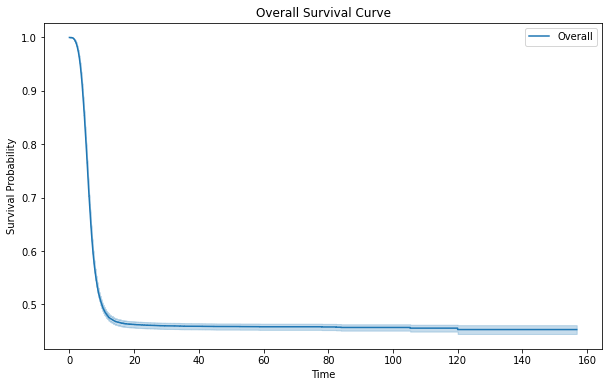

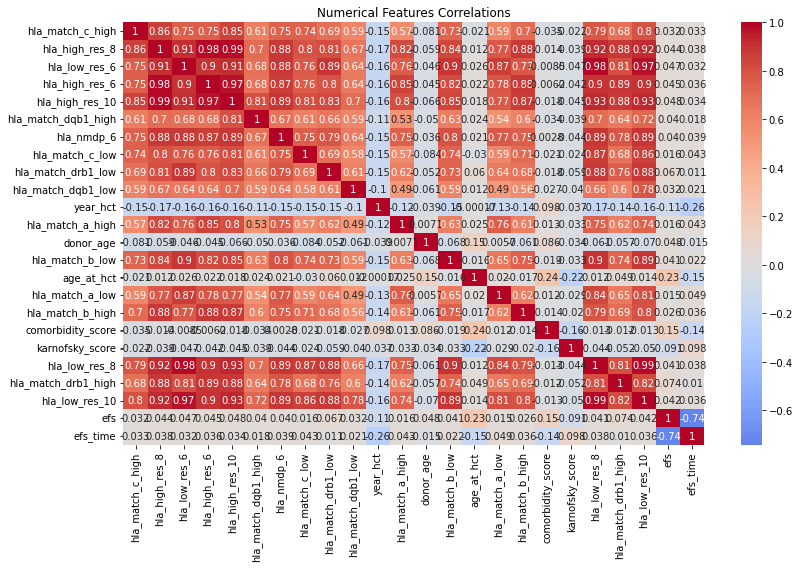

In [2]:
train_df, test_df, data_dict = load_data()

explore_data(train_df, plot_survival_curves=False)

In [ ]:
train_processed, test_processed = preprocess_data(train_df, test_df)
model = build_model(train_processed)



Iteration 1: norm_delta = 7.52e-01, step_size = 0.9500, log_lik = -154145.54142, newton_decrement = 2.97e+03, seconds_since_start = 4.0
Iteration 2: norm_delta = 2.10e-01, step_size = 0.9500, log_lik = -151375.86803, newton_decrement = 1.74e+02, seconds_since_start = 8.1
Iteration 3: norm_delta = 4.07e-02, step_size = 0.9500, log_lik = -151194.57143, newton_decrement = 4.26e+00, seconds_since_start = 13.0
Iteration 4: norm_delta = 3.21e-03, step_size = 1.0000, log_lik = -151190.16023, newton_decrement = 2.10e-02, seconds_since_start = 18.3
Iteration 5: norm_delta = 6.20e-05, step_size = 1.0000, log_lik = -151190.13903, newton_decrement = 6.35e-06, seconds_since_start = 22.8
Iteration 6: norm_delta = 4.09e-08, step_size = 1.0000, log_lik = -151190.13903, newton_decrement = 2.69e-12, seconds_since_start = 28.0
Convergence success after 6 iterations.


In [11]:
preds = make_predictions(model, test_processed)

In [15]:
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ID,-5.726420e-07,0.999999,9.685773e-07,-0.000002,0.000001,0.999998,1.000001,0.0,-0.591220,5.543732e-01,0.851071
hla_match_c_high,3.871591e-02,1.039475,2.095226e-02,-0.002350,0.079782,0.997653,1.083050,0.0,1.847816,6.462897e-02,3.951675
hla_high_res_8,-1.246129e-01,0.882839,6.345166e-02,-0.248976,-0.000250,0.779599,0.999750,0.0,-1.963903,4.954129e-02,4.335225
hla_low_res_6,-4.803417e-02,0.953101,8.648402e-02,-0.217540,0.121471,0.804496,1.129157,0.0,-0.555411,5.786136e-01,0.789328
hla_high_res_6,2.630439e-02,1.026653,6.422947e-02,-0.099583,0.152192,0.905215,1.164384,0.0,0.409538,6.821451e-01,0.551849
...,...,...,...,...,...,...,...,...,...,...,...
"melphalan_dose_N/A, Mel not given",7.308561e-02,1.075823,2.074755e-02,0.032421,0.113750,1.032952,1.120472,0.0,3.522614,4.273138e-04,11.192416
cardiac_Not done,-1.955556e-01,0.822378,1.197121e-01,-0.430187,0.039076,0.650387,1.039849,0.0,-1.633549,1.023535e-01,3.288367
cardiac_Yes,2.854899e-01,1.330414,3.192841e-02,0.222911,0.348068,1.249710,1.416329,0.0,8.941560,3.837132e-19,61.176605
